In [1]:
# =============================================================================
# OUTLIER DETECTION (FEATURE-ENGINEERED SPACE) - Isolation Forest
# =============================================================================
#
# - Uses matches_with_engineered_features.csv (same features used for modeling)
# - Only ATP main tour matches (Qualifying_match == 0)
# - Focuses on a curated numeric subset (strength, experience, recency)
# - Fits Isolation Forest to find unusual matches in this feature space
# - Visualizes and profiles outliers for the report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [2]:
# =============================================================================
# STEP 1: Load Feature-Engineered Dataset (ATP Main Only)
# =============================================================================

# This is the same dataset used in ozafa_modeling_and_evaluation.ipynb

df = pd.read_csv('../data/processed/matches_with_engineered_features.csv')
print(f"Shape before ATP filter: {df.shape}")

# Keep only ATP main tour matches (Qualifying_match == 0)
df = df[df['Qualifying_match'] == 0].copy()
print(f"Shape after ATP filter (ATP main only): {df.shape}")

print("\nColumns (first 20):", df.columns.tolist()[:20])


Shape before ATP filter: (161807, 132)
Shape after ATP filter (ATP main only): (42356, 132)

Columns (first 20): ['player1_rank', 'player1_rank_imputed', 'player1_ht', 'player1_age', 'player2_rank', 'player2_rank_imputed', 'player2_ht', 'player2_age', 'player1_won', 'draw_size', 'tourney_date', 'best_of', 'Qualifying_match', 'player1_hand_L', 'player1_hand_R', 'player1_hand_U', 'player2_hand_L', 'player2_hand_R', 'player2_hand_U', 'player1_entry_2) A']


In [3]:
# =============================================================================
# STEP 2: Select Numeric Features for Isolation Forest (Engineered Space)
# =============================================================================

# We choose a curated subset of numeric, model-relevant features:
# - Strength / skill: rank_difference, career_win_rate_diff, recent_form_diff
# - Experience: player*_career_matches
# - Win rates: player*_career_win_rate, surface win-rate diffs
# - Recency: player*_recent_form

candidate_features = [
    # basic strength / differences
    'rank_difference',
    'career_win_rate_diff',
    'recent_form_diff',

    # experience
    'player1_career_matches', 'player2_career_matches',

    # overall win rates
    'player1_career_win_rate', 'player2_career_win_rate',

    # surface win-rate diffs (if present)
    'clay_win_rate_diff', 'grass_win_rate_diff', 'hard_win_rate_diff', 'carpet_win_rate_diff',

    # recent form
    'player1_recent_form', 'player2_recent_form',

    # head-to-head
    'h2h_matches', 'player1_h2h_win_rate', 'player2_h2h_win_rate', 'h2h_win_rate_diff',
]

# Drop columns that should never go into Isolation Forest
cols_to_exclude = {
    'player1_won', 'Qualifying_match', 'tourney_date',
    'player1_id', 'player2_id', 'player1_name', 'player2_name',
}

existing_features = [c for c in candidate_features if c in df.columns and c not in cols_to_exclude]
missing_features = [c for c in candidate_features if c not in df.columns]

print("Existing engineered features used for Isolation Forest ({}):".format(len(existing_features)))
print(existing_features)

if missing_features:
    print("\n(These candidate features were not found and are ignored):")
    print(missing_features)

X = df[existing_features].copy()

# Simple median imputation for any remaining NaNs (should be rare)
X = X.fillna(X.median(numeric_only=True))

print("\nShape of X for Isolation Forest:", X.shape)
print("Any remaining NaNs?", X.isnull().any().any())


Existing engineered features used for Isolation Forest (17):
['rank_difference', 'career_win_rate_diff', 'recent_form_diff', 'player1_career_matches', 'player2_career_matches', 'player1_career_win_rate', 'player2_career_win_rate', 'clay_win_rate_diff', 'grass_win_rate_diff', 'hard_win_rate_diff', 'carpet_win_rate_diff', 'player1_recent_form', 'player2_recent_form', 'h2h_matches', 'player1_h2h_win_rate', 'player2_h2h_win_rate', 'h2h_win_rate_diff']

Shape of X for Isolation Forest: (42356, 17)
Any remaining NaNs? False


In [4]:
# =============================================================================
# STEP 3: Scale Features and Fit Isolation Forest (Engineered Space)
# =============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature means after scaling (approx 0):", X_scaled.mean(axis=0)[:5])
print("Feature stds after scaling (approx 1):", X_scaled.std(axis=0)[:5])

iso = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=0.02,  # ~2% outliers
    random_state=42,
    n_jobs=-1,
)

iso.fit(X_scaled)

# decision_function: higher = more normal, lower = more anomalous
df['if_score'] = iso.decision_function(X_scaled)
# label: 1 = normal, -1 = outlier
df['if_label'] = iso.predict(X_scaled)

print("\nIsolation Forest labels:")
print(df['if_label'].value_counts())
print("\nLabel proportions:")
print(df['if_label'].value_counts(normalize=True))


Feature means after scaling (approx 0): [-9.81366277e-18  4.02611806e-18  3.01958855e-18 -5.36815741e-18
  4.16032200e-17]
Feature stds after scaling (approx 1): [1. 1. 1. 1. 1.]

Isolation Forest labels:
if_label
 1    41508
-1      848
Name: count, dtype: int64

Label proportions:
if_label
 1    0.979979
-1    0.020021
Name: proportion, dtype: float64


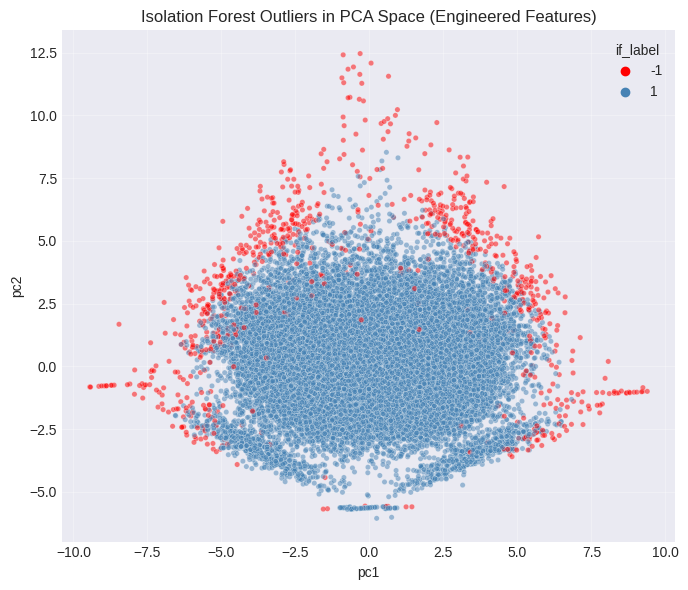

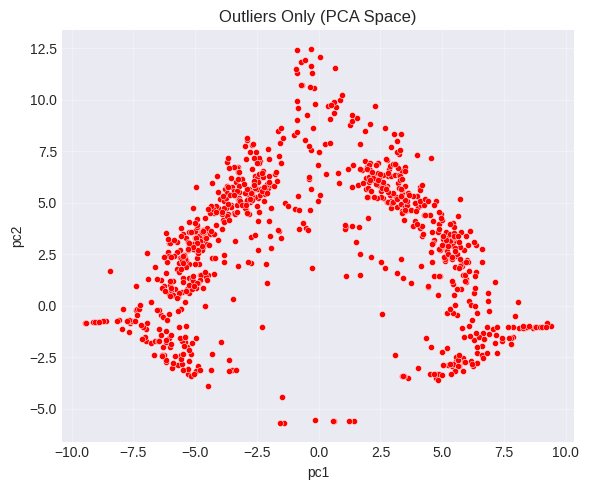

In [5]:
# =============================================================================
# STEP 4: PCA Visualization of Outliers
# =============================================================================

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df['pc1'] = X_pca[:, 0]
df['pc2'] = X_pca[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x='pc1', y='pc2',
    hue='if_label',
    palette={1: 'steelblue', -1: 'red'},
    alpha=0.5,
    s=15,
)
plt.title('Isolation Forest Outliers in PCA Space (Engineered Features)')
plt.legend(title='if_label', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Outliers only
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df[df['if_label'] == -1],
    x='pc1', y='pc2',
    color='red',
    s=20,
)
plt.title('Outliers Only (PCA Space)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Mean feature values for normal (1) vs outlier (-1) matches:

          rank_difference  career_win_rate_diff  recent_form_diff  player1_career_matches  player2_career_matches  player1_career_win_rate  player2_career_win_rate  clay_win_rate_diff  grass_win_rate_diff  hard_win_rate_diff  carpet_win_rate_diff  player1_recent_form  player2_recent_form  h2h_matches  h2h_win_rate_diff
if_label                                                                                                                                                                                                                                                                                                                        
-1                -10.736                -0.031            -0.035                 363.574                 374.251                    0.614                    0.645              -0.003               -0.007              -0.021                 0.001                0.615                0.650        

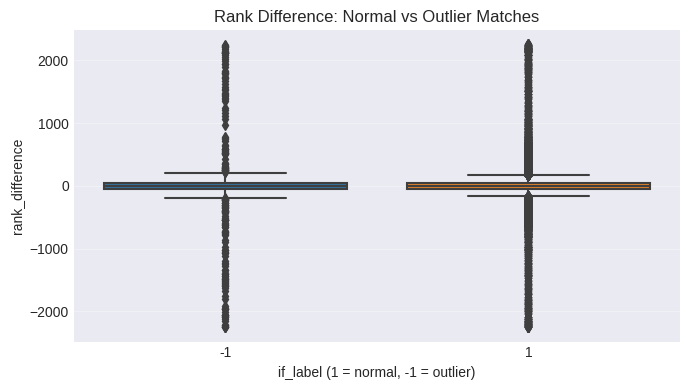

In [6]:
# =============================================================================
# STEP 5: Profile Outliers vs Normal Matches
# =============================================================================

compare_cols = [
    c for c in [
        'rank_difference',
        'career_win_rate_diff',
        'recent_form_diff',
        'player1_career_matches', 'player2_career_matches',
        'player1_career_win_rate', 'player2_career_win_rate',
        'clay_win_rate_diff', 'grass_win_rate_diff', 'hard_win_rate_diff', 'carpet_win_rate_diff',
        'player1_recent_form', 'player2_recent_form',
        'h2h_matches', 'h2h_win_rate_diff',
    ] if c in df.columns
]

profile = df.groupby('if_label')[compare_cols].mean().round(3)
print("\nMean feature values for normal (1) vs outlier (-1) matches:\n")
print(profile.to_string())

# Example boxplot: rank_difference normal vs outlier
if 'rank_difference' in df.columns:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x='if_label', y='rank_difference')
    plt.title('Rank Difference: Normal vs Outlier Matches')
    plt.xlabel('if_label (1 = normal, -1 = outlier)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [7]:
# =============================================================================
# STEP 6: Save Engineered-Space Outlier Flags (Optional)
# =============================================================================

# This is purely for analysis; you don't have to consume this in modeling
# unless you explicitly decide to later.

output_flagged = '../data/processed/matches_with_engineered_features_if.csv'
df.to_csv(output_flagged, index=False)
print(f"\n✓ Saved engineered-space outlier flags to: {output_flagged}")

# If you ever want a filtered version (no outliers):
df_if_no_out = df[df['if_label'] == 1].copy()
output_filtered = '../data/processed/matches_with_engineered_features_if_no_outliers.csv'
df_if_no_out.to_csv(output_filtered, index=False)
print(f"✓ Saved engineered-space filtered dataset (no outliers) to: {output_filtered}")

print("\nRows before filtering:", len(df))
print("Rows after filtering:", len(df_if_no_out))



✓ Saved engineered-space outlier flags to: ../data/processed/matches_with_engineered_features_if.csv
✓ Saved engineered-space filtered dataset (no outliers) to: ../data/processed/matches_with_engineered_features_if_no_outliers.csv

Rows before filtering: 42356
Rows after filtering: 41508
